# Part 3 - Visualising Particle Tracks

When running neutronics simulations we may want to track how particles travel through the defined geometry.

This python notebook allows users to generate particle track files that can be opened and viewed alongside the 3D geometry.

This first code block makes a geometry with hemispheres. One side is a moderator (H2O) and the other is a material that is quite transparent to neutrons (zirconium).

Because of the different neutronic properties of the materials, we expect neutrons to track differently through the two materials. We can visualise this using OpenMC.

In [1]:
import openmc
import os
openmc.config['cross_sections'] = '/home/nuclearkid/openmc_conda/openmc_data/endfb80/endfb-viii.0-hdf5/cross_sections.xml'

# MATERIALS
mats = openmc.Materials()

moderating_material = openmc.Material(42, "water")  # water contains hydrogen which is a good neutron moderator, note the ID number is 42, we need this later
moderating_material.add_element('H', 2, 'ao')  # Note, 'percent_type=' does not have to be written to specify 'ao' or 'wo'
moderating_material.add_element('O', 1, 'ao')
moderating_material.set_density('g/cm3', 1.0)
mats.append(moderating_material)

transparent_material = openmc.Material(82, "zirconium")  # one of the more transparent materials, note the ID number is 42, we need this later
transparent_material.add_element('Zr', 1, 'ao')
transparent_material.set_density('g/cm3', 6.49)
mats.append(transparent_material)


# GEOMETRY
sph0 = openmc.Sphere(r=400)
sph1 = openmc.Sphere(r=600, boundary_type='vacuum')
flat_surf = openmc.YPlane(y0=0)

simple_moderator_cell = openmc.Cell(region=+sph0 & -sph1 & +flat_surf)
simple_moderator_cell.fill = moderating_material

simple_transparent_cell = openmc.Cell(region=+sph0 & -sph1 & -flat_surf)
simple_transparent_cell.fill = transparent_material

vaccum_cell = openmc.Cell(region=-sph0)

geom = openmc.Geometry([simple_moderator_cell, simple_transparent_cell, vaccum_cell])


# SIMULATION SETTINGS

# Instantiate a Settings object
sett = openmc.Settings()
batches = 1
sett.batches = batches
sett.inactive = 0
sett.particles = 10  # Note that only 10 particles are simulated, otherwise we make too many files
sett.particle = "neutron"
sett.run_mode = 'fixed source'

# creates a 14MeV point source
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0, 0, 0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1])

# source.file = 'source_1000_particles.h5'
sett.source = source

This is the new part covered by this task. The running of OpenMC in track mode.

In [2]:
# Run OpenMC!
model = openmc.model.Model(geom, mats, sett)
model.run(tracks=True)  # this creates h5 files that contain track information

[juan-ASUS-TUF-Gaming-F15:12973] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.juan-ASUS-TUF-Gaming-F15.1000/jf.0/2453209088/shared_mem_cuda_pool.juan-ASUS-TUF-Gaming-F15 could be created.
[juan-ASUS-TUF-Gaming-F15:12973] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
          

PosixPath('/home/nuclearkid/IB/Quinto Semestre/PI/NeutronicsWorkshop/neutronics-workshop/tasks/task_04_make_sources/statepoint.1.h5')

Loading the track output file and plotting the results

In [3]:
tracks = openmc.Tracks('tracks.h5')

Makes a quick 3D plot of the tracks.

<Axes3D: xlabel='x [cm]', ylabel='y [cm]', zlabel='z [cm]'>

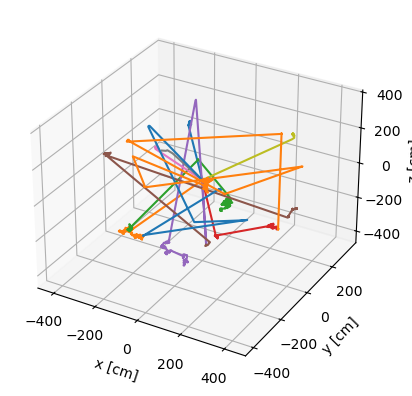

In [4]:
tracks.plot()

This exports the tracks.h5 files to vtk / vtp files which can be opened with Paraview to show the tracks in 3d.

In [5]:
tracks.write_to_vtk('tracks.vtp')

<vtkmodules.vtkCommonDataModel.vtkPolyData(0x6489b65b8d40) at 0x7af15e86c6a0>

Cycles through each of the tracks printing information on each track

In [6]:
# gets the first track from the 10 tracks. This is 10 because we simulated 10 particles
track = tracks[0]

# get the primary particle track from this particle
one_particle = track.particle_tracks[0]

# prints out the x position, y position, z position, x direction, y direction, z direction, energy, weight (varience reduction is off), cell id and material id
print(one_particle.states)

# Notice the energy starts at 14MeV and decreases with each collision

[((   0.        ,   0.        ,  0.        ), (-0.66165219,  0.7456147 ,  7.92154954e-02), 1.40000000e+07, 0.00000000e+00, 1., 3, 0, -1)
 ((-264.66087519, 298.24588176, 31.68619815), (-0.66165219,  0.7456147 ,  7.92154954e-02), 1.40000000e+07, 7.81511637e-08, 1., 1, 0, 42)
 ((-265.39525145, 299.0734491 , 31.77412045), (-0.02368145,  0.9423578 , -3.33767825e-01), 6.69506077e+06, 7.83680161e-08, 1., 1, 0, 42)
 ((-265.43482482, 300.64819511, 31.216371  ), ( 0.11755527, -0.59746849, -7.93228948e-01), 5.68047779e+06, 7.88374307e-08, 1., 1, 0, 42)
 ((-265.23722523, 299.64390555, 29.88302612), (-0.10197062,  0.737343  ,  6.67777874e-01), 4.42245693e+06, 7.93496332e-08, 1., 1, 0, 42)
 ((-265.54815923, 301.89224932, 31.91924836), (-0.2746274 ,  0.96148452, -1.12833934e-02), 2.35113587e+06, 8.04016389e-08, 1., 1, 0, 42)
 ((-267.34513686, 308.18355959, 31.8454174 ), ( 0.48526355,  0.43978064, -7.55719710e-01), 2.07080652e+05, 8.34926577e-08, 1., 1, 0, 42)
 ((-266.93289416, 308.5571635 , 31.203415

Filtering of tracks is also easy with the built in filter method.

There are 10 tracks in total as we simulated just 10 particles.

However we can filter these 10 particles to look at the ones that interacted with water then we could inspect the properties of tracks in certain materials.

In [7]:
tracks_in_zirconium_material = tracks.filter(state_filter=lambda s:s['material_id'] == 82)
# writing a separate vtk file for the tracks that go through the zirconium material 
tracks_in_zirconium_material.write_to_vtk('tracks_in_zirconium_material.vtp')

tracks_in_water_material = tracks.filter(state_filter=lambda s:s['material_id'] == 42)
# writing a separate vtk file for the tracks that go through the water material 
tracks_in_water_material.write_to_vtk('tracks_in_water_material.vtp')

print(f'{len(tracks_in_water_material)} tracks in water and {len(tracks_in_zirconium_material)}')

9 tracks in water and 5


This next code block might be familiar from task 3. Here, we are converting the geometry into a 3D version which can be viewed. This will provide a nice background for the tracks so we know where are relative to the materials.

If you were working with CAD geometry you could load up STL files or use mbconvert to convert a dagmc.h5m to a VTK file.

Mesh tallies (in VTK format) as you can visualize the geometry together with the source in Paraview

In [8]:
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.width = (1300., 1300., 1300.)
vox_plot.pixels = (100, 100, 100)
vox_plot.filename = 'plot_3d'
vox_plot.color_by = 'material'
vox_plot.colors = {moderating_material: 'blue', transparent_material: 'red'}
plots = openmc.Plots([vox_plot])
plots.export_to_xml()

openmc.plot_geometry()
# openmc-voxel-to-vtk is a python script distributed with openmc
os.system('openmc-voxel-to-vtk plot_3d.h5 -o plot_3d.vti')

[juan-ASUS-TUF-Gaming-F15:13058] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.juan-ASUS-TUF-Gaming-F15.1000/jf.0/1732902912/shared_mem_cuda_pool.juan-ASUS-TUF-Gaming-F15 could be created.
[juan-ASUS-TUF-Gaming-F15:13058] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
          

0

Right mouse click on the vtp files in the file explorer to download the vtk file to your base computer and open it with a VTK file reader such as Paraview or Visit.

Paraview can be downloaded here: https://www.paraview.org/download/.
Visit can be downloaded here https://wci.llnl.gov/simulation/computer-codes/visit/downloads.


**Learning Outcomes for Part 3:**

- Particle tracks through geometry can be tracked in OpenMC and visualised in programs such as Paraview and Visit.